In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import os
import time
import copy
import pandas as pd
from os import listdir
from PIL import Image
from torchvision import datasets, models, transforms
from sklearn.metrics import confusion_matrix

In [2]:
dataset_dir = '../Dataset'
model_name = 'alexnet'
num_classes = 15
batch_size = 128
num_epochs = 25
feature_extract = True

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(dataset_dir, x), data_transforms[x]) for x in ['train', 'val']}

dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
torch.cuda.get_device_name(0)

'GeForce 840M'

In [6]:
def initialize_alexnet(model_name, num_classes, feature_extract=True, use_pretrained=True):

  model_ft = None
  input_size = 0

  if model_name == "alexnet":
    model_ft = models.alexnet(pretrained=use_pretrained)

    if feature_extract:
        for param in model_ft.parameters():
            param.requires_grad = False
    
    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)

    input_size = 224
  else:
        print("Model name is invalid!")
        exit()

  return model_ft,input_size

model_ft, input_size = initialize_alexnet(model_name, num_classes, feature_extract)

print(model_ft)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [7]:
model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
print("Parameters to learn")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

optimizer_ft = optim.SGD(params_to_update, lr=0.01, momentum=0.9)

Parameters to learn
	 classifier.6.weight
	 classifier.6.bias


In [8]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []
    train_acc_history = []
    val_loss_history = []
    train_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch: {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 30)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            else: 
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('-' * 35)
    print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best validation accuracy: {:4f}'.format(best_acc))
    print('-' * 35)

    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history, val_loss_history, train_loss_history

criterion = nn.CrossEntropyLoss()

model_ft, val_acc_hist, train_acc_hist, val_loss_hist, train_loss_hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch: 1/25
------------------------------
train Loss: 1.7096 Acc: 0.4113
val Loss: 1.2801 Acc: 0.6150

Epoch: 2/25
------------------------------
train Loss: 1.2654 Acc: 0.6169
val Loss: 0.9460 Acc: 0.7200

Epoch: 3/25
------------------------------
train Loss: 1.2322 Acc: 0.6438
val Loss: 1.4704 Acc: 0.5900

Epoch: 4/25
------------------------------
train Loss: 1.2594 Acc: 0.6338
val Loss: 1.0703 Acc: 0.7200

Epoch: 5/25
------------------------------
train Loss: 1.2301 Acc: 0.6462
val Loss: 1.0132 Acc: 0.6950

Epoch: 6/25
------------------------------
train Loss: 1.0873 Acc: 0.6725
val Loss: 0.9745 Acc: 0.7200

Epoch: 7/25
------------------------------
train Loss: 1.0663 Acc: 0.6825
val Loss: 1.0559 Acc: 0.6675

Epoch: 8/25
------------------------------
train Loss: 0.9164 Acc: 0.7094
val Loss: 0.7419 Acc: 0.7850

Epoch: 9/25
------------------------------
train Loss: 0.9537 Acc: 0.7044
val Loss: 0.9281 Acc: 0.7175

Epoch: 10/25
------------------------------
train Loss: 0.9956 A

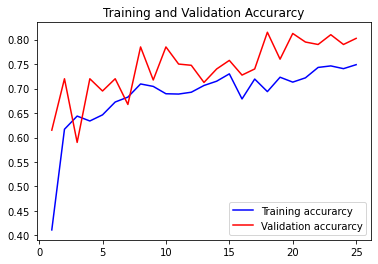

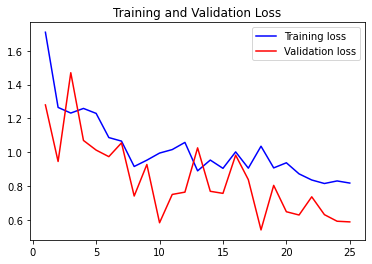

In [9]:
plt.title("Training and Validation Accurarcy")
plt.plot(range(1,num_epochs+1),train_acc_hist,'b',label="Training accurarcy")
plt.plot(range(1,num_epochs+1),val_acc_hist,'r',label="Validation accurarcy")
plt.legend()
plt.show()

plt.title("Training and Validation Loss")
plt.plot(range(1,num_epochs+1),train_loss_hist,'b',label="Training loss")
plt.plot(range(1,num_epochs+1),val_loss_hist,'r',label="Validation loss")
plt.legend()
plt.show()

In [10]:
model_path = '../experiment_alexnet_model.sav'
torch.save(model_ft.state_dict(), model_path)

In [11]:
labels_path = '../experiment_alexnet_label.csv'

def save_class_labels(class_labels_path):
    labels_dict = image_datasets['train'].class_to_idx
    labels_df = pd.DataFrame.from_dict(data=labels_dict, orient='index', columns=['idx'])
    labels_df['Label'] = labels_df.index
    labels_df.reset_index(drop=True, inplace=True)
    labels_df.to_csv(class_labels_path, header=None, index=False)

save_class_labels(labels_path)

In [12]:
def initialize_alexnet(model_name, num_classes, feature_extract=True, use_pretrained=True):

  model_ft = None
  input_size = 0

  if model_name == "alexnet":
    model_ft = models.alexnet(pretrained=use_pretrained)

    if feature_extract:
        for param in model_ft.parameters():
            param.requires_grad = False
    
    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)

    input_size = 224
  else:
        print("Model name is invalid!")
        exit()

  return model_ft,input_size

model, _ = initialize_alexnet("alexnet", num_classes=15)
model.load_state_dict(torch.load(model_path))
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [13]:
labels_df = pd.read_csv(labels_path, header=None, names=['idx','Label'])
labels_dict = dict(zip(labels_df.idx, labels_df.Label))

In [14]:
def predict(img):
    transform = transforms.Compose([            
    transforms.Resize(256),                    
    transforms.CenterCrop(224),                
    transforms.ToTensor(),                     
    transforms.Normalize(                      
    mean=[0.485, 0.456, 0.406],                
    std=[0.229, 0.224, 0.225]                  
    )])

    img_t = transform(img)
    batch_t = torch.unsqueeze(img_t, 0)  
    out = model(batch_t)
    _, index = torch.max(out, 1)
    
    return index

def get_label(labels_dict, idx=-1):
    if (idx>=0 and idx<=14):
        label = labels_dict[idx]
    else:
        label = ''
    return label

In [15]:
test_data_dir = '../Dataset/val'

In [18]:
actual_label_list = []
predicted_lebel_list = []
list_test_data_dir = listdir(test_data_dir)
for leaf_image_dir in list_test_data_dir :
        image_list = listdir(f"{test_data_dir}/{leaf_image_dir}")
        for image in image_list:
          image_file = f"{test_data_dir}/{leaf_image_dir}/{image}"
          if image_file.endswith(".jpg") == True or image_file.endswith(".JPG") == True:
            actual_label_list.append(leaf_image_dir)
            img = Image.open(image_file)
            pred_idx = predict(img)
            predicted_lebel = get_label(labels_dict, pred_idx.numpy()[0])
            predicted_lebel_list.append(predicted_lebel)

In [19]:
cm = confusion_matrix(actual_label_list, predicted_lebel_list)

In [20]:
print("Calculating AlexNet model accuracy")
scores = (cm.trace()/cm.sum())
print(f"Test Accuracy: {scores*100}")

Calculating AlexNet model accuracy
Test Accuracy: 81.5
